# Making some quick calculations to get $F_{ij}$ working for $C_l^{TT},C_l^{TE},C_l^{EE}$ observables

In [2]:
import crosspower as cp
#import FisherCl as fcl
#import FisherCl2 as fcl
#from numpy.linalg import eigh
import camb

# set plotting to be in the notebook instead of its own qt window
%matplotlib inline

In [3]:
# set cosmological parameters
cosParams = {
        'H0'    : None, #67.51, #setting H0=None allows cosmomc_theta to be used instead
        'cosmomc_theta'           : 1.04087e-2,
        'ombh2' : 0.02226,
        'omch2' : 0.1193,
        'omk'   : 0,
        'tau'   : 0.063,

        'As'    : 2.130e-9,
        'ns'    : 0.9653,
        'r'     : 0,
        'kPivot': 0.05,

        # if fiducial mnu is changed, need to adjust omch2 as well
        'mnu'   : 0.06, # (eV)
        #'mnu'   : 0.058, # Lloyd suggested this value for fiducial; adjust omch2 if I do use it
        'nnu'   : 3.046,
        'standard_neutrino_neff'  : 3.046,
        'num_massive_neutrinos'   : 1,
        'neutrino_hierarchy'      : 'normal'}

In [4]:
# get a matterPower object
reload(cp)
myPk = cp.matterPower(**cosParams)

zs.size:  998


In [5]:
# copy some setup from FisherCl2.py

#myParams = myPk.cosParams
myParams = cosParams
nz = 1000

# parameters list:
nCosParams = 7 # 6 LCDM + Mnu
paramList = ['ombh2','omch2','cosmomc_theta','As','ns','tau','mnu']
# step sizes for discrete derivatives: must correspond to paramList entries!
#   from Allison et. al. (2015) Table III.
deltaP = [0.0008,0.0030,0.0050e-2,0.1e-9,0.010,0.020,0.020] #last one in eV

# get more matterPower objects for numeric differentiation
print 'creating more matter power objects...'
myParamsUpper = []
myParamsLower = []
myPksUpper = []
myPksLower = []
for cParamNum in range(nCosParams):
    print 'creating matter power spectra for ',paramList[cParamNum],' derivative...'
    # add parameter dictionary to lists; HAVE TO BE COPIES!!!
    myParamsUpper.append(myParams.copy())
    myParamsLower.append(myParams.copy())
    # modify parameter number cParamNum in dictionaries
    myParamsUpper[cParamNum][paramList[cParamNum]] += deltaP[cParamNum]
    myParamsLower[cParamNum][paramList[cParamNum]] -= deltaP[cParamNum]

    
    # toggle this section off for comparison with Kevin's Fisher result:
    """
    # check for mnu modification and adjust omch2 if necessary
    if paramList[cParamNum] == 'mnu':
        omch2Index = np.where(np.array(paramList) == 'omch2')[0][0]
        deltaOmnh2 = deltaP[cParamNum]/94 #eq.n 12 from Wu et. al.
        #deltaOmnh2 = pars.omegan*(pars.H0/100)**2 # probably a better measure of omega_nu
        # note the -=,+= signs get reversed in next 2 lines compared to above
        myParamsUpper[cParamNum][paramList[omch2Index]] -= deltaOmnh2
        myParamsLower[cParamNum][paramList[omch2Index]] += deltaOmnh2
    """

    #print 'cPramNum: ',cParamNum,', param name: ',paramList[cParamNum]
    #print 'myParamsUpper[cParamNum][paramList[cParamNum]]: ',myParamsUpper[cParamNum][paramList[cParamNum]]
    #print 'myParamsLower[cParamNum][paramList[cParamNum]]: ',myParamsLower[cParamNum][paramList[cParamNum]]
    #print 'deltaP[cParamNum]: ',deltaP[cParamNum]

    # create matter power objects and add to lists
    myPksUpper.append(cp.matterPower(nz=nz,**myParamsUpper[cParamNum]))
    myPksLower.append(cp.matterPower(nz=nz,**myParamsLower[cParamNum]))



creating more matter power objects...
creating matter power spectra for  ombh2  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  omch2  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  cosmomc_theta  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  As  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  ns  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  tau  derivative...
zs.size:  998
zs.size:  998
creating matter power spectra for  mnu  derivative...
zs.size:  998
zs.size:  998


In [6]:
# get all cross power spectra
lmax = 2000 # may want to match lmax in other Fisher calculation
pars = myPk.pars
pars.set_for_lmax(lmax, lens_potential_accuracy=0)

#calculate results for these parameters
print 'getting Cl power spectrum'
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars)
#for name in powers: print name

#get the total lensed CMB power spectra versus unlensed
#myClName = 'total'
myClName = 'unlensed_scalar'
myCl = powers[myClName]

#totCl=powers['total']
#unlensedCl=powers['unlensed_scalar']
print myCl.shape
#Python Cl arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).

# re-arrange the data structure to be consistent with code in FisherMatrix
nMaps = 2 # T,E
#crossCls      = np.zeros((nMaps,nMaps,           lmax+51)) # the 51 is a CAMB feature
#crossClsPlus  = np.zeros((nMaps,nMaps,nCosParams,lmax+51))
#crossClsMinus = np.zeros((nMaps,nMaps,nCosParams,lmax+51))
# try without the excess 51, since Cl is not really supposed to be accurate there.
crossCls      = np.zeros((nMaps,nMaps,           lmax))
crossClsPlus  = np.zeros((nMaps,nMaps,nCosParams,lmax))
crossClsMinus = np.zeros((nMaps,nMaps,nCosParams,lmax))

crossCls[0,0] = myCl[:lmax,0] # TT
crossCls[0,1] = myCl[:lmax,3] # TE
crossCls[1,0] = myCl[:lmax,3] # ET
crossCls[1,1] = myCl[:lmax,1] # EE

# get the perturbed versions
for paramNum in range(nCosParams):
    print 'getting Cl power spectra for parameter ',paramList[paramNum]
    parsUpper = myPksUpper[paramNum].pars
    parsLower = myPksLower[paramNum].pars
    parsUpper.set_for_lmax(lmax, lens_potential_accuracy=0)
    parsLower.set_for_lmax(lmax, lens_potential_accuracy=0)

    #calculate results for these parameters
    resultsUpper = camb.get_results(parsUpper)
    resultsLower = camb.get_results(parsLower)

    #get dictionary of CAMB power spectra
    powersUpper =resultsUpper.get_cmb_power_spectra(parsUpper)
    powersLower =resultsLower.get_cmb_power_spectra(parsLower)
    
    #get the lensed power spectra
    myClUpper=powersUpper[myClName]
    myClLower=powersLower[myClName]
    
    #store them
    crossClsPlus[0,0,paramNum]  = myClUpper[:lmax,0] # TT
    crossClsPlus[0,1,paramNum]  = myClUpper[:lmax,3] # TE
    crossClsPlus[1,0,paramNum]  = myClUpper[:lmax,3] # ET
    crossClsPlus[1,1,paramNum]  = myClUpper[:lmax,1] # EE

    crossClsMinus[0,0,paramNum] = myClLower[:lmax,0] # TT
    crossClsMinus[0,1,paramNum] = myClLower[:lmax,3] # TE
    crossClsMinus[1,0,paramNum] = myClLower[:lmax,3] # ET
    crossClsMinus[1,1,paramNum] = myClLower[:lmax,1] # EE

    


getting Cl power spectrum
(2051, 4)
getting Cl power spectra for parameter  ombh2
getting Cl power spectra for parameter  omch2
getting Cl power spectra for parameter  cosmomc_theta
getting Cl power spectra for parameter  As
getting Cl power spectra for parameter  ns
getting Cl power spectra for parameter  tau
getting Cl power spectra for parameter  mnu


In [9]:
# convert power spectra to "bandpowers"
bandWidth = 5 # number of ell values per "band"
bandNumMax = lmax/bandWidth # should be integer
print 'band number max: ',bandNumMax
crossBPs      = np.zeros((nMaps,nMaps,           bandNumMax))
crossBPsPlus  = np.zeros((nMaps,nMaps,nCosParams,bandNumMax))
crossBPsMinus = np.zeros((nMaps,nMaps,nCosParams,bandNumMax))

# wow, 5 nested for loops!  This blows!
for bandNum in range(bandNumMax):
    for ellNum in range(bandWidth):
        for iObs in range(nMaps):
            for jObs in range(nMaps):
                crossBPs[iObs,jObs,bandNum] += crossCls[iObs,jObs,bandNum*bandWidth+ellNum]
                for paramNum in range(nCosParams):
                    crossBPsPlus[iObs,jObs,paramNum,bandNum] += \
                        crossClsPlus[iObs,jObs,paramNum,bandNum*bandWidth+ellNum]
                    crossBPsMinus[iObs,jObs,paramNum,bandNum] += \
                        crossClsMinus[iObs,jObs,paramNum,bandNum*bandWidth+ellNum]

# divide to complete the averaging
crossBPs /= bandWidth
crossBPsPlus /= bandWidth
crossBPsMinus /= bandWidth
# note: this has not accounted for the absence of ell=1 from first band

band number max:  400


In [30]:
# more code from FisherMatrix.__init__
# create covariance matrix
print 'building covariance matrix... '

nCls = nMaps*(nMaps+1)/2 # This way removes redundancies, eg C_l^kg = C_l^gk
#covar = np.zeros((nCls,nCls,lmax+51))
#ells = np.arange(lmax+51)
covar = np.zeros((nCls,nCls,lmax))
ells = np.arange(lmax)

# create obsList to contain base nMaps representation of data label
obsList = np.zeros(nCls)

for map1 in range(nMaps):
    print 'starting covariance set ',map1+1,' of ',nMaps,'... '
    for map2 in range(map1, nMaps):
        covIndex1 = map1*nMaps+map2-map1*(map1+1)/2     # shortens the array
        obsList[covIndex1] = map1*nMaps+map2       # base nMaps representation
        for map3 in range(nMaps):
          for map4 in range(map3, nMaps):
            covIndex2 = map3*nMaps+map4-map3*(map3+1)/2 # shortens the array
            if covIndex1 <= covIndex2:
              covar[covIndex1,covIndex2] = (crossCls[map1,map3]*crossCls[map2,map4] + \
                                            crossCls[map1,map4]*crossCls[map2,map3] )/(2.*ells+1)
            else:                                       # avoid double calculation
              covar[covIndex1,covIndex2] = covar[covIndex2,covIndex1]
            
# band up the covar too
covarBP = np.zeros((nCls,nCls,bandNumMax))
for bandNum in range(bandNumMax):
    for ellNum in range(bandWidth):
        covarBP[:,:,bandNum] += covar[:,:,bandNum*bandWidth+ellNum]
covarBP /= (bandWidth**2)


# invert covariance matrix
print 'inverting covariance matrix... '
# transpose of inverse of transpose is inverse of original
# need to do this to get indices in order that linalg.inv wants them
invCov = np.transpose(np.linalg.inv(np.transpose(covar[:,:,2:])))
ells = ells[2:]
print 'lmin = ',ells[0]
print 'obsList: ',obsList

# invert the covarBP
invCovBP = np.transpose(np.linalg.inv(np.transpose(covarBP)))

building covariance matrix... 
starting covariance set  1  of  2 ... 
starting covariance set  2  of  2 ... 
inverting covariance matrix... 
lmin =  2
obsList:  [ 0.  1.  3.]


In [31]:
# get derivatives wrt parameters
print 'starting creation of C_l derivatives... '
#dClVecs = np.empty((nCls, nCosParams, lmax+51))
#Clzeros = np.zeros(lmax+51) # for putting into dClVecs when needed

#dClVecs = np.empty((nCls, nCosParams, lmax))
dBPVecs = np.empty((nCls, nCosParams, bandNumMax))

for map1 in range(nMaps):
    print 'starting derivative set ',map1+1,' of ',nMaps,'... '
    for map2 in range(map1,nMaps):
        mapIdx  = map1*nMaps+map2 -map1*(map1+1)/2  
                                   # mapIdx = map index
        for pIdx in range(nCosParams):
            #dClPlus  = crossClsPlus[map1,map2,pIdx]
            #dClMinus = crossClsMinus[map1,map2,pIdx]
            #dClVecs[mapIdx, pIdx] = (dClPlus-dClMinus)/(2*deltaP[pIdx])
            dBPPlus  = crossBPsPlus[map1,map2,pIdx]
            dBPMinus = crossBPsMinus[map1,map2,pIdx]
            dBPVecs[mapIdx, pIdx] = (dBPPlus-dBPMinus)/(2*deltaP[pIdx])


starting creation of C_l derivatives... 
starting derivative set  1  of  2 ... 
starting derivative set  2  of  2 ... 


In [32]:
#Build Fisher matrix
lmin = 50 #to match Allison et. al. and justify no ISW effect
bandNumMin = lmin/bandWidth
print 'band num min: ',bandNumMin,', band num max: ',bandNumMax
#multply vectorT,invcov,vector and add up
print 'building Fisher matrix from components...'
#print 'invCov.shape: ',invCov.shape,', dClVecs.shape: ',dClVecs.shape
print 'invCovBP.shape: ',invCovBP.shape,', dBPVecs.shape: ',dBPVecs.shape
Fij = np.zeros((nCosParams,nCosParams)) # indices match those in paramList
for i in range(nCosParams):
    print 'starting bin set ',i+1,' of ',nCosParams
    #dClVec_i = dClVecs[:,i,:] # shape (nCls,nElls)
    dBPVec_i = dBPVecs[:,i,:] # shape (nCls,nBands)
    for j in range(nCosParams):
        #dClVec_j = dClVecs[:,j,:] # shape (nCls,nElls)
        dBPVec_j = dBPVecs[:,j,:] # shape (nCls,nBands)
        # ugh.  don't like nested loops in Python... but easier to program...
        #for ell in range(lmin-2,lmax+51-2):
        #for ell in range(lmin-2,lmax-2):
        for bandNum in range(bandNumMin,bandNumMax):
          #myCov = invCov[:,:,ell]  #note invCov has no ell=0,1 but dClVecs do
          myCovBP = invCovBP[:,:,bandNum]
          #fij = np.dot(dClVec_i[:,ell+2],np.dot(myCov,dClVec_j[:,ell+2]))
          fij = np.dot(dBPVec_i[:,bandNum],np.dot(myCovBP,dBPVec_j[:,bandNum]))
          Fij[i,j] += fij
    
print 'creation of Fisher Matrix complete!\n'

# Have a look at it
print 'Fij:'
print Fij
# check eigenvalues
w,v = np.linalg.eigh(np.linalg.inv(Fij))
print 'eigenvalues of F_ij^-1:'
print w

band num min:  10 , band num max:  400
building Fisher matrix from components...
invCovBP.shape:  (3, 3, 400) , dBPVecs.shape:  (3, 7, 400)
starting bin set  1  of  7
starting bin set  2  of  7
starting bin set  3  of  7
starting bin set  4  of  7
starting bin set  5  of  7
starting bin set  6  of  7
starting bin set  7  of  7
creation of Fisher Matrix complete!

Fij:
[[  1.01308621e+09   3.87386194e+07   2.46442357e+09   4.01516556e+15
    1.95079437e+07  -1.71005010e+07   5.68077628e+04]
 [  3.87386194e+07   1.70509918e+07   2.91557760e+09  -2.67912689e+15
   -2.10919171e+06   1.14071079e+07   1.62458215e+04]
 [  2.46442357e+09   2.91557760e+09   4.02693595e+12  -3.33104220e+17
   -6.80837916e+08   1.41912258e+09   2.37141498e+07]
 [  4.01516556e+15  -2.67912689e+15  -3.33104220e+17   8.81492308e+23
    1.28750691e+15  -3.75446465e+15  -4.43848324e+11]
 [  1.95079437e+07  -2.10919171e+06  -6.80837916e+08   1.28750691e+15
    2.69799566e+06  -5.48709606e+06  -9.66983318e+02]
 [ -1.710

In [33]:
# add prior on Tau for comparison with Kevin's result
tauNum = 5
tauPrior = 1/0.02**2
print Fij[tauNum,tauNum]
Fij[tauNum,tauNum] = Fij[tauNum,tauNum] + tauPrior 
print Fij[tauNum,tauNum]

15991197.5799
15993697.5799


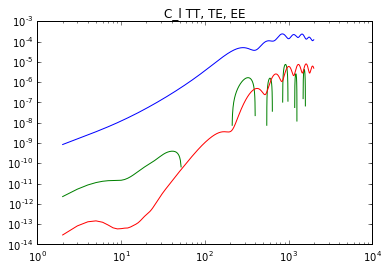

In [34]:
# just take a look at TT, TE, EE
plt.loglog(ells,crossCls[0,0,2:]*ells*(ells+1))
#plt.loglog(ells,crossCls[0,1,2:]*ells*(ells+1))
plt.loglog(ells,crossCls[1,0,2:]*ells*(ells+1))
plt.loglog(ells,crossCls[1,1,2:]*ells*(ells+1))
plt.title('C_l TT, TE, EE');

# Check out these uncertainties!

In [35]:
sigmas = np.sqrt(np.diag(np.linalg.inv(Fij)))
for i,p in enumerate(paramList):
    print p, sigmas[i]

ombh2 3.87107539171e-05
omch2 0.000566866643445
cosmomc_theta 1.41024241483e-06
As 8.32689303863e-11
ns 0.00169797886032
tau 0.0195825139419
mnu 0.217177546635


In [36]:
# get lensing and galaxy Fisher matrix to add
import FisherCl2 as fcl
import pickle
filehandler2 = open('Fisher_4_4.obj', 'r') 
Fobj = pickle.load(filehandler2) 

print Fobj.obsList
print Fobj.paramList

[  0.   1.   2.   3.   4.   6.   7.   8.   9.  12.  13.  14.  18.  19.  24.]
['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'bin1', 'bin2', 'bin3', 'bin4']


In [37]:
# remake the kappa-g Fij with lmin=50 to match the other Fij
# make comparison against version with higher lmin
# copy some code from FisherMatrix.__init__

def makeFisher(Fobj,lmin):
    """ code copied from FisherMatrix.__init__
        Inputs:
            Fobj:
            lmin: minimum ell to make Fij
    """
    #Build Fisher matrix
    #multply vectorT,invcov,vector and add up
    print 'building Fisher matrix from components...'
    print 'invCov.shape: ',Fobj.invCov.shape,', dClVecs.shape: ',Fobj.dClVecs.shape
    nParams = Fobj.nParams
    lmax = 2000 #Fobj.lmax
    Fij = np.zeros((nParams,nParams)) # indices match those in paramList
    for i in range(nParams):
      print 'starting bin set ',i+1,' of ',nParams
      dClVec_i = Fobj.dClVecs[:,i,:] # shape (nCls,nElls)
      for j in range(nParams):
        dClVec_j = Fobj.dClVecs[:,j,:] # shape (nCls,nElls)
        # ugh.  don't like nested loops in Python... but easier to program...
        for ell in range(lmin-2,lmax-1): #-2 to match the indices
          myCov = Fobj.invCov[:,:,ell]
          fij = np.dot(dClVec_i[:,ell],np.dot(myCov,dClVec_j[:,ell]))
          
          Fij[i,j] += fij
    
    print 'creation of Fisher Matrix complete!\n'
    return Fij

In [38]:
Fij2 = makeFisher(Fobj,50)
sigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))

building Fisher matrix from components...
invCov.shape:  (15, 15, 1999) , dClVecs.shape:  (15, 11, 1999)
starting bin set  1  of  11
starting bin set  2  of  11
starting bin set  3  of  11
starting bin set  4  of  11
starting bin set  5  of  11
starting bin set  6  of  11
starting bin set  7  of  11
starting bin set  8  of  11
starting bin set  9  of  11
starting bin set  10  of  11
starting bin set  11  of  11
creation of Fisher Matrix complete!



In [39]:
print 'comparison of T,E sigmas with kappa,g sigmas:'
#sigmas2 = Fobj.getSigmas()
for i,p in enumerate(paramList):
    print p, sigmas[i],sigmas2[i]

comparison of T,E sigmas with kappa,g sigmas:
ombh2 3.87107539171e-05 0.000440831221394
omch2 0.000566866643445 0.000890127314305
cosmomc_theta 1.41024241483e-06 1.47199830004e-05
As 8.32689303863e-11 2.0507238059e-11
ns 0.00169797886032 0.00212105153535
tau 0.0195825139419 0.910496254903
mnu 0.217177546635 0.0166473588192


# Combine the Fisher matrices and see smaller sigmas

In [40]:
print 'comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):\n'
#FijSum = Fij+Fobj.Fij[:nCosParams,:nCosParams]  #oops, that was the lmin=2 version
FijSum = Fij+Fij2[:nCosParams,:nCosParams]   # this one has lmin=50
#print FijSum
#print FijSum-Fij
#print FijSum-Fij2[:nCosParams,:nCosParams]
sigmas3 = np.sqrt(np.diag(np.linalg.inv(FijSum)))
#for i,p in enumerate(paramList):
#    print p, sigmas[i],sigmas2[i],sigmas3[i]
    
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma(T,E)','sigma(k,g)','sigma(T,E,k,g)'])
for i,p in enumerate(paramList):
    t.add_row([p,"%5.3g" % sigmas[i],"%5.3g" % sigmas2[i],"%5.3g" % sigmas3[i]])
print t

comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):

+---------------+------------+------------+----------------+
|   Parameter   | sigma(T,E) | sigma(k,g) | sigma(T,E,k,g) |
+---------------+------------+------------+----------------+
|     ombh2     |  3.87e-05  |  0.000441  |    3.13e-05    |
|     omch2     |  0.000567  |  0.00089   |    0.000161    |
| cosmomc_theta |  1.41e-06  |  1.47e-05  |     5e-07      |
|       As      |  8.33e-11  |  2.05e-11  |    1.14e-11    |
|       ns      |   0.0017   |  0.00212   |    0.000983    |
|      tau      |   0.0196   |    0.91    |    0.00298     |
|      mnu      |   0.217    |   0.0166   |    0.00791     |
+---------------+------------+------------+----------------+


In [41]:
# the previous result fixed the biases for the combined sigmas.
# do a different version without fixing them
print 'comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):\n'
FijSum2 = Fij2.copy()
#print FijSum2
FijSum2[:nCosParams,:nCosParams] = FijSum2[:nCosParams,:nCosParams] + Fij
#print Fij2
#print FijSum2
#print FijSum2-Fij2

sigmas4 = np.append(sigmas,[0,0,0,0])
#FijSum = Fij+Fobj.Fij[:nCosParams,:nCosParams]
sigmas5 = np.sqrt(np.diag(np.linalg.inv(FijSum2)))
#for i,p in enumerate(Fobj.paramList):
#    print p, sigmas4[i],sigmas2[i],sigmas5[i]
    
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma(T,E)','sigma(k,g)','sigma(T,E,k,g)'])
for i,p in enumerate(Fobj.paramList):
    t.add_row([p,"%5.3g" % sigmas4[i],"%5.3g" % sigmas2[i],"%5.3g" % sigmas5[i]])
print t

comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):

+---------------+------------+------------+----------------+
|   Parameter   | sigma(T,E) | sigma(k,g) | sigma(T,E,k,g) |
+---------------+------------+------------+----------------+
|     ombh2     |  3.87e-05  |  0.000441  |    3.16e-05    |
|     omch2     |  0.000567  |  0.00089   |    0.000249    |
| cosmomc_theta |  1.41e-06  |  1.47e-05  |    5.29e-07    |
|       As      |  8.33e-11  |  2.05e-11  |    1.55e-11    |
|       ns      |   0.0017   |  0.00212   |    0.00113     |
|      tau      |   0.0196   |    0.91    |    0.00395     |
|      mnu      |   0.217    |   0.0166   |     0.0131     |
|      bin1     |       0    |  0.00348   |    0.00246     |
|      bin2     |       0    |  0.00305   |    0.00281     |
|      bin3     |       0    |  0.00346   |    0.00319     |
|      bin4     |       0    |  0.00434   |    0.00382     |
+---------------+------------+------------+----------------+


To add:
    switch to halofit
    shot noise
    lensing recon noise
    DE params
    Improved bias model  (important but hard; not for 'first paper')
    Inverted nu hiearchy: Is there any sensitivity beyond Sigma mnu (transition region)
        (drawing: power stepping down for each species instead of one step down with ell)
        Ll: guesses probably not

priorities: byeonhee,kevin comparisons,
    include DE
    inverted nu hier
    halofit
    noise

In [42]:
# compare to Kevin's result
Ksigmas = {
    'As' : 8.36787928685e-11,
    'cosmomc_theta' : 1.44400712682e-06,
    'mnu' : 0.220088883622,
    'ns' : 0.00193696953962,
    'ombh2' : 4.50012028332e-05,
    'omch2' : 0.000630720967738,
    'tau' : 0.0196834629721
}

In [43]:
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma_Z(T,E)','sigma_K(T,E)','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas[i]
    Ki = Ksigmas[paramList[i]]
    diff = (Ki-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Ki, "%5.3g" % diff ] )
print t

+---------------+--------------+--------------+---------------+
|   Parameter   | sigma_Z(T,E) | sigma_K(T,E) | percent diff. |
+---------------+--------------+--------------+---------------+
|     ombh2     |   3.87e-05   |   4.5e-05    |      16.2     |
|     omch2     |   0.000567   |   0.000631   |      11.3     |
| cosmomc_theta |   1.41e-06   |   1.44e-06   |      2.39     |
|       As      |   8.33e-11   |   8.37e-11   |     0.492     |
|       ns      |    0.0017    |   0.00194    |      14.1     |
|      tau      |    0.0196    |    0.0197    |     0.516     |
|      mnu      |    0.217     |     0.22     |      1.34     |
+---------------+--------------+--------------+---------------+


In [44]:
# check out Kevin's pickle
filehandler3 = open('test_cov_for_z.pkl', 'r') 
Kdict = pickle.load(filehandler3) 

ValueError: unsupported pickle protocol: 3